In [25]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from portfolio_management_helper import calc_cummulative_returns

## 2. Investigating Momentum

### 2.1 Is Momentum Still Profitable?
#### A

In [3]:
df = pd.read_excel("momentum_data.xlsx", sheet_name="momentum (excess returns)")
factors = pd.read_excel("momentum_data.xlsx", sheet_name="factors (excess returns)")

In [4]:
df.set_index("Date", inplace=True)
factors.set_index("Date", inplace=True)

In [5]:
pd.Series(factors['MKT'].corr(df['UMD']))

0   -0.347742
dtype: float64

In [6]:
df.mean(axis=0)

UMD    0.006092
dtype: float64

In [7]:
df_1927_2024 = pd.DataFrame([df.mean(axis=0) * 12, df.std() * np.sqrt(12), df.mean()*12/df.std() / np.sqrt(12), df.skew(), pd.Series(factors['MKT'].corr(df['UMD']), index=["UMD"]), 
                             pd.Series(factors['HML'].corr(df['UMD']), index=["UMD"])], index=['mean', 'vol', 'sharpe', 'skew', 'corr_to_market', 'corr_to_value']).rename(columns={"UMD":"1927-2024"}).T
df_1927_1993 = pd.DataFrame([df.loc["1927":"1993"].mean(axis=0) * 12, df.loc["1927":"1993"].std() * np.sqrt(12), df.loc["1927":"1993"].mean()*12/df.loc["1927":"1993"].std() / np.sqrt(12), df.loc["1927":"1993"].skew(), 
                             pd.Series(factors['MKT'].corr(df.loc["1927":"1993"]['UMD']), index=["UMD"]), pd.Series(factors['HML'].corr(df.loc["1927":"1993"]['UMD']), index=["UMD"])], 
                             index=['mean', 'vol', 'sharpe', 'skew', 'corr_to_market', 'corr_to_value']).rename(columns={"UMD":"1927-1993"}).T
df_1927_2008 = pd.DataFrame([df.loc["1993":"2008"].mean(axis=0) * 12, df.loc["1993":"2008"].std() * np.sqrt(12), df.loc["1993":"2008"].mean()*12/df.loc["1993":"2008"].std() / np.sqrt(12), df.loc["1993":"2008"].skew(), 
                             pd.Series(factors['MKT'].corr(df.loc["1993":"2008"]['UMD']), index=["UMD"]), pd.Series(factors['HML'].corr(df.loc["1993":"2008"]['UMD']), index=["UMD"])], 
                             index=['mean', 'vol', 'sharpe', 'skew', 'corr_to_market', 'corr_to_value']).rename(columns={"UMD":"1993-2008"}).T
df_2009_2024 = pd.DataFrame([df.loc["2009":"2025"].mean(axis=0) * 12, df.loc["2009":"2025"].std() * np.sqrt(12), df.loc["2009":"2025"].mean()*12/df.loc["2009":"2025"].std() / np.sqrt(12), df.loc["2009":"2025"].skew(), 
                             pd.Series(factors['MKT'].corr(df.loc["2009":"2025"]['UMD']), index=["UMD"]), pd.Series(factors['HML'].corr(df.loc["2009":"2025"]['UMD']), index=["UMD"])], 
                             index=['mean', 'vol', 'sharpe', 'skew', 'corr_to_market', 'corr_to_value']).rename(columns={"UMD":"2009-2025"}).T

result = pd.concat([df_1927_2024, df_1927_1993, df_1927_2008, df_2009_2024], axis=0)
result

,mean,vol,sharpe,skew,corr_to_market,corr_to_value
1927-2024,0.073109,0.162364,0.450276,-3.062415,-0.347742,-0.410478
1927-1993,0.088136,0.160513,0.549089,-3.911021,-0.367499,-0.500962
1993-2008,0.109381,0.171699,0.637052,-0.630596,-0.230990,-0.091966
2009-2025,-0.013962,0.155914,-0.089550,-2.676247,-0.358740,-0.325477


### B
**Based on the result above, the momentum factor has changed over the years in mean return and sharpe ratio. The mean return has decreased and became negative from 2009 to 2024**

### C
**By looking at the total mean return from 1927-2024, the data does support AQR's argument that momentum is an important piece of the ideal portfolio. If mean returns to momentum are actually near zero, then momentum is not an important piece of the ideal portfolio**

### 2.2 Long only implementation of momentum

In [11]:
sort_momentum = pd.read_excel("momentum_data.xlsx", sheet_name="size_sorts (total returns)")
risk_free = pd.read_excel("momentum_data.xlsx", sheet_name="risk-free rate")
risk_free.set_index("Date", inplace=True)
sort_momentum.set_index("Date", inplace=True)
sort_momentum.head()

,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR
Date,,,,,,
1927-01-31,-0.0001,0.0369,0.0050,-0.0040,0.0006,0.0023
1927-02-28,0.0673,0.0635,0.0582,0.0655,0.0398,0.0445
1927-03-31,-0.0315,-0.0314,-0.0199,-0.0364,-0.0018,0.0225
1927-04-30,-0.0070,-0.0046,0.0348,-0.0272,0.0073,0.0181
1927-05-31,0.0250,0.1123,0.0664,0.0550,0.0504,0.0692


In [28]:
my_momentum_factor = 0.5 * (sort_momentum['SMALL HiPRIOR'] + sort_momentum["BIG HiPRIOR"]) - risk_free['RF']
my_momentum_factor = my_momentum_factor.loc["1994":"2024"]

In [29]:
my_momentum_mean = my_momentum_factor.mean() * 12
my_momentum_vol = my_momentum_factor.std() * np.sqrt(12)
my_momentum_sharpe = my_momentum_mean / my_momentum_vol
my_momentum_skew = my_momentum_factor.skew()
my_momentum_corr_to_market = factors['MKT'].corr(my_momentum_factor)
my_momentum_corr_to_value = factors['HML'].corr(my_momentum_factor)


fama_momentum_mean = df['UMD'].loc["1994":"2024"].mean() * 12
fama_momentum_vol = df['UMD'].loc["1994":"2024"].std() * np.sqrt(12)
fama_momentum_sharpe = fama_momentum_mean / fama_momentum_vol
fama_momentum_skew = df['UMD'].loc["1994":"2024"].skew()
fama_momentum_corr_to_market = factors['MKT'].corr(df['UMD'].loc["1994":"2024"])
fama_momentum_corr_to_value = factors['HML'].corr(df['UMD'].loc["1994":"2024"])

momentum_summary = pd.DataFrame({'mean': [my_momentum_mean, fama_momentum_mean], 'vol': [my_momentum_vol, fama_momentum_vol], 
                                 'sharpe': [my_momentum_sharpe, fama_momentum_sharpe], 'skew': [my_momentum_skew, fama_momentum_skew], 
                                 'corr_to_market': [my_momentum_corr_to_market, fama_momentum_corr_to_market], 
                                 'corr_to_value': [my_momentum_corr_to_value, fama_momentum_corr_to_value]}, index = ['My Momentum Factor', 'Fama-French UMD Factor'])
momentum_summary

,mean,vol,sharpe,skew,corr_to_market,corr_to_value
My Momentum Factor,0.1161,0.1780,0.6524,-0.4420,0.9040,-0.1163
Fama-French UMD Factor,0.0431,0.1672,0.2575,-1.4610,-0.3105,-0.2104


### B and C
- Long only momentum has better mean, worse vol, and better sharpe than Farma French momentum factor, but significantly worse for diversifaction, it has an extremely high correlation to the market factor

### D

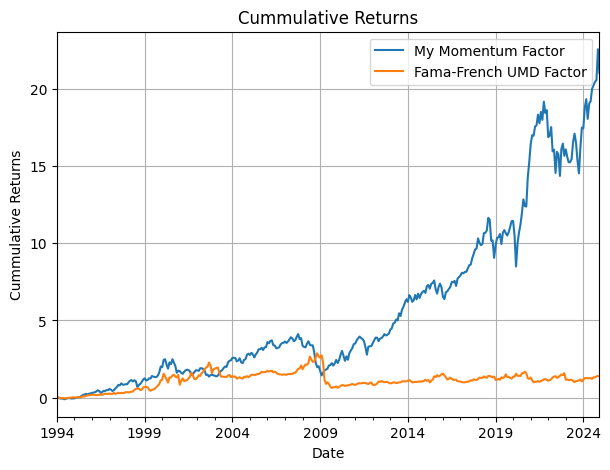

In [30]:

combined_momentum = pd.DataFrame({'My Momentum Factor': my_momentum_factor, 'Fama-French UMD Factor': df['UMD'].loc["1994":"2024"]})
calc_cummulative_returns(returns=combined_momentum)

## 2.3

In [39]:
decil_data = pd.read_excel("momentum_data.xlsx", sheet_name="deciles (total returns)")
decil_data.set_index("Date", inplace=True)
decil_data = decil_data.loc["1994":"2025"]
decil_data.head()

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
Date,,,,,,,,,,
1994-01-31,0.0668,0.0395,0.0278,0.0096,0.0309,0.0208,0.0266,0.0399,0.0301,0.0484
1994-02-28,-0.0144,-0.0144,-0.0273,-0.0325,-0.0210,-0.0236,-0.0243,-0.0251,-0.0274,-0.0116
1994-03-31,-0.0488,-0.0416,-0.0414,-0.0289,-0.0434,-0.0395,-0.0502,-0.0495,-0.0483,-0.0572
1994-04-30,-0.0159,0.0054,0.0174,0.0234,0.0131,0.0207,0.0064,0.0076,-0.0094,0.0032
1994-05-31,0.0153,0.0155,0.0133,0.0153,0.0106,0.0104,0.0146,0.0052,0.0050,-0.0216


In [40]:
return_long_top_1_bottom_1 = decil_data['Hi PRIOR'] - decil_data['Lo PRIOR']
return_long_top_3_bottom_3 = (decil_data['Hi PRIOR'] + decil_data['PRIOR 9'] + decil_data['PRIOR 8'])/3 - (decil_data['Lo PRIOR'] + decil_data['PRIOR 2'] + decil_data['PRIOR 3'])/3
return_long_top_5_bottom_5 = (decil_data['Hi PRIOR'] + decil_data['PRIOR 9'] + decil_data['PRIOR 8'] + decil_data['PRIOR 7'] + decil_data['PRIOR 6'])/5 - (decil_data['Lo PRIOR'] + decil_data['PRIOR 2'] + decil_data['PRIOR 3'] + decil_data['PRIOR 4'] + decil_data['PRIOR 5'])/5

decile_momentum = pd.DataFrame({'Long Top 1 Bottom 1': return_long_top_1_bottom_1, 
                               'Long Top 3 Bottom 3': return_long_top_3_bottom_3, 
                               'Long Top 5 Bottom 5': return_long_top_5_bottom_5})
decile_momentum

,Long Top 1 Bottom 1,Long Top 3 Bottom 3,Long Top 5 Bottom 5
Date,,,
1994-01-31,-0.0184,-0.0052,-0.0018
1994-02-28,0.0028,-0.0027,-0.0005
1994-03-31,-0.0084,-0.0077,-0.0081
1994-04-30,0.0191,-0.0018,-0.0030
1994-05-31,-0.0369,-0.0185,-0.0113
...,...,...,...
2025-04-30,0.1218,0.0660,0.0412
2025-05-31,-0.0278,0.0273,-0.0006
2025-06-30,-0.0426,-0.0409,-0.0220


In [41]:
decile_mean = decile_momentum.mean() * 12
decile_vol = decile_momentum.std() * np.sqrt(12)
decile_sharpe = decile_mean / decile_vol
decile_skew = decile_momentum.skew()
decile_corr_market = decile_momentum.apply(lambda col: factors['MKT'].corr(col))
decile_corr_value = decile_momentum.apply(lambda col: factors['HML'].corr(col))

decile_summary = pd.DataFrame({
    'mean': decile_mean,
    'vol': decile_vol,
    'sharpe': decile_sharpe,
    'skew': decile_skew,
    'corr_to_market': decile_corr_market,
    'corr_to_value': decile_corr_value
})

decile_summary

,mean,vol,sharpe,skew,corr_to_market,corr_to_value
Long Top 1 Bottom 1,0.0742,0.2987,0.2484,-1.2714,-0.3202,-0.2455
Long Top 3 Bottom 3,0.0267,0.1931,0.1385,-1.3196,-0.3543,-0.2210
Long Top 5 Bottom 5,0.0155,0.1335,0.1163,-1.4077,-0.3490,-0.2143


- The trade off matches up, the more extreme decile you pick the higher the mean return and the higher the vol

## D
- Long and short top and bottom 3 decil has similar performance to the Fama French construction in part 1, with higher average mean excess return and higher sharpe ratio

## 2.4

In [46]:
small_stock_momentum = sort_momentum['SMALL HiPRIOR'] - sort_momentum['SMALL LoPRIOR']
big_stock_momentum = sort_momentum['BIG HiPRIOR'] - sort_momentum['BIG LoPRIOR']
all_stocks = df['UMD']

total_momentum = pd.DataFrame({
    'Small Stock Momentum': small_stock_momentum,
    'Big Stock Momentum': big_stock_momentum,
    'All Stocks Momentum': all_stocks
})
total_momentum = total_momentum.loc["1994":"2024"]

In [47]:
total_momentum_mean = total_momentum.mean() * 12
total_momentum_vol = total_momentum.std() * np.sqrt(12)
total_momentum_sharpe = total_momentum_mean / total_momentum_vol
total_momentum_skew = total_momentum.skew()
total_momentum_corr_market = total_momentum.apply(lambda col: factors['MKT'].corr(col))

total_momentum_summary = pd.DataFrame({
    'mean': total_momentum_mean,
    'vol': total_momentum_vol,
    'sharpe': total_momentum_sharpe,
    'skew': total_momentum_skew,
    'corr_to_market': total_momentum_corr_market
})
total_momentum_summary

,mean,vol,sharpe,skew,corr_to_market
Small Stock Momentum,0.0614,0.1691,0.3631,-1.8042,-0.3102
Big Stock Momentum,0.0246,0.1823,0.1351,-0.8745,-0.2819
All Stocks Momentum,0.0431,0.1672,0.2575,-1.4610,-0.3105
